# Visual Data Predictions with Multimodal Topic Mining

**Student Name:** Georgios Kitsakis

**Course:** Advanced Customer Analytics

**Assignment:** HW2: Visual Data Predictions - 2025

---

## Dataset

**Source:** Flickr30k - Image Captioning Dataset  
**Link:** https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset  
**Size:** 31,783 images with 5 human-annotated captions each

**Features:**
- Images: 31,783 diverse photos of people, objects, scenes, and activities
- Captions: 5 descriptive captions per image (158,915 total)
- **Sample Size:** 5,000 images used for this analysis

**Prediction Task:** 
1. **Topic Mining:** Can we discover meaningful visual topics from images and captions using multimodal embeddings?
2. **Classification:** Can we predict the topic label of an image using combined image-text features?

---

## Assignment Goals

This notebook implements two required functions:

1. **`topic_miner()`** - Uses BERTopic with multimodal CLIP embeddings to:
   - Combine image and caption features
   - Discover latent topics automatically
   - Label each image with its discovered topic

2. **`predict()`** - Trains classifiers using BERTopic labels to:
   - Split data into 70-30 train/test
   - Train multiple models (Random Forest, Logistic Regression, SVM)
   - Return confusion matrix and performance metrics

**Best Result:** 97.6% accuracy with Logistic Regression

---

## 1. Setup and Installation

In [1]:
!pip install -q bertopic[vision] kagglehub scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 6.8 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from bertopic import BERTopic
from bertopic.backend import MultiModalBackend
from bertopic.representation import VisualRepresentation
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


## 2. Download Dataset

In [3]:
dataset_path = kagglehub.dataset_download("hsankesara/flickr-image-dataset")
print(f"Dataset path: {dataset_path}")

100%|██████████| 8.16G/8.16G [00:59<00:00, 147MB/s] 

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/hsankesara/flickr-image-dataset/versions/1


## 3. Load and Prepare Data

In [4]:
# Load captions
captions_file = os.path.join(dataset_path, 'flickr30k_images', 'results.csv')
df = pd.read_csv(captions_file, delimiter='|')
df.columns = df.columns.str.strip()

# Use first caption per image
df_processed = df.groupby('image_name').first().reset_index()
print(f"Total images: {len(df_processed)}")

# Set image folder path
image_folder = os.path.join(dataset_path, 'flickr30k_images', 'flickr30k_images')
num_images = len([f for f in os.listdir(image_folder) if f.endswith('.jpg')])
print(f"Images found: {num_images}")

Total images: 31783
Images found: 31783


## 4. Function 1: topic_miner()

Identifies multimodal topics using BERTopic and labels each image.

In [5]:
def topic_miner(image_folder, captions_df, image_col='image_name', caption_col='comment',
                min_cluster_size=50, nr_topics='auto', sample_size=None):
    """
    Identifies multimodal topics using BERTopic and labels each image.

    Parameters:
    -----------
    image_folder : str
        Path to folder containing images
    captions_df : pd.DataFrame
        DataFrame with image names and captions
    image_col : str
        Column name for image filenames
    caption_col : str
        Column name for captions
    min_cluster_size : int
        Minimum cluster size for HDBSCAN
    nr_topics : str or int
        Number of topics ('auto' or specific number)
    sample_size : int or None
        Number of images to sample (None = use all)

    Returns:
    --------
    labeled_df : pd.DataFrame
        DataFrame with columns: image_path, caption, topic_label, topic_name
    topic_model : BERTopic
        Trained BERTopic model
    embeddings : np.array
        Combined embeddings for classification
    """

    if sample_size and sample_size < len(captions_df):
        captions_df = captions_df.sample(n=sample_size, random_state=42).reset_index(drop=True)

    # Load images and captions
    image_paths, captions, images = [], [], []

    for idx, row in tqdm(captions_df.iterrows(), total=len(captions_df), desc="Loading images"):
        img_path = os.path.join(image_folder, row[image_col])
        if os.path.exists(img_path):
            try:
                img = Image.open(img_path).convert("RGB")
                images.append(img)
                image_paths.append(img_path)
                captions.append(str(row[caption_col]))
            except Exception as e:
                continue

    print(f"Loaded {len(images)} images")

    # Create multimodal embeddings with CLIP
    backend_model = MultiModalBackend('clip-ViT-B-32', batch_size=32)
    caption_embeddings = backend_model.embed_documents(captions)
    image_embeddings = backend_model.embed_images(images, verbose=1)
    combined_embeddings = (caption_embeddings + image_embeddings) / 2

    print(f"Embeddings shape: {combined_embeddings.shape}")

    # Configure BERTopic
    hdbscan_model = HDBSCAN(
        min_cluster_size=min_cluster_size,
        metric='euclidean',
        cluster_selection_method='eom',
        min_samples=5,
        prediction_data=True
    )

    visual_model = VisualRepresentation(nr_repr_images=3)
    vectorizer_model = CountVectorizer(stop_words="english")

    topic_model = BERTopic(
        vectorizer_model=vectorizer_model,
        embedding_model=None,
        representation_model={"Visual_Aspect": visual_model},
        hdbscan_model=hdbscan_model,
        nr_topics=nr_topics
    )

    # Train BERTopic
    topics, probs = topic_model.fit_transform(
        documents=captions,
        embeddings=combined_embeddings,
        images=image_paths
    )

    topic_info = topic_model.get_topic_info()
    print(f"Discovered {len(topic_info) - 1} topics")
    print(f"Outliers: {(np.asarray(topics) == -1).sum()} images")

    # Create labeled dataframe
    labeled_df = pd.DataFrame({
        'image_path': image_paths,
        'caption': captions,
        'topic_label': topics,
        'topic_probability': probs
    })

    topic_names = {row['Topic']: row['Name'] for _, row in topic_info.iterrows()}
    labeled_df['topic_name'] = labeled_df['topic_label'].map(topic_names)

    return labeled_df, topic_model, combined_embeddings

## 5. Function 2: predict()

Trains a classifier using BERTopic labels and returns confusion matrix.

In [6]:
def predict(labeled_df, embeddings, test_size=0.3, classifier='random_forest', remove_outliers=True):
    """
    Trains a classifier using BERTopic labels and returns confusion matrix.

    Parameters:
    -----------
    labeled_df : pd.DataFrame
        Output from topic_miner() with topic labels
    embeddings : np.array
        Combined embeddings from topic_miner()
    test_size : float
        Proportion of test set (default 0.3 for 70-30 split)
    classifier : str
        Classifier type: 'random_forest', 'logistic', 'svm'
    remove_outliers : bool
        Whether to remove topic -1 (outliers) before training

    Returns:
    --------
    conf_matrix : np.array
        Confusion matrix
    model : sklearn classifier
        Trained model
    metrics : dict
        Dictionary with accuracy and classification report
    """

    X = embeddings
    y = labeled_df['topic_label'].values

    if remove_outliers:
        mask = y != -1
        X = X[mask]
        y = y[mask]
        print(f"Removed {(~mask).sum()} outliers")

    print(f"Training on {len(y)} samples with {len(np.unique(y))} classes")

    # Split data 70-30
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    print(f"Train: {len(X_train)} | Test: {len(X_test)}")

    # Select and train classifier
    if classifier == 'random_forest':
        model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
    elif classifier == 'logistic':
        model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
    elif classifier == 'svm':
        model = SVC(kernel='rbf', random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"\nClassification Report:\n{class_report}")

    metrics = {
        'accuracy': accuracy,
        'classification_report': class_report,
        'y_test': y_test,
        'y_pred': y_pred
    }

    return conf_matrix, model, metrics

## 6. Visualization Functions

In [7]:
def plot_confusion_matrix(conf_matrix, title='Confusion Matrix'):
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
    plt.title(title, fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

def visualize_topics(topic_model, labeled_df, n_topics=10):
    topic_info = topic_model.get_topic_info()
    topic_info = topic_info[topic_info['Topic'] != -1].head(n_topics)

    print(f"\nTop {n_topics} Topics:")
    print("=" * 80)
    for _, row in topic_info.iterrows():
        keywords = ', '.join([w for w, _ in topic_model.get_topic(row['Topic'])[:10]])
        print(f"Topic {row['Topic']}: {row['Name']}")
        print(f"  Count: {row['Count']} | Keywords: {keywords}\n")

    # Topic distribution plot
    topic_counts = labeled_df[labeled_df['topic_label'] != -1]['topic_label'].value_counts().sort_index()
    plt.figure(figsize=(14, 6))
    topic_counts.plot(kind='bar', color='steelblue')
    plt.title('Topic Distribution', fontsize=16, fontweight='bold')
    plt.xlabel('Topic ID', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 7. Run Topic Mining

In [8]:
labeled_df, topic_model, embeddings = topic_miner(
    image_folder=image_folder,
    captions_df=df_processed,
    min_cluster_size=30,
    sample_size=5000
)

Loading images: 100%|██████████| 5000/5000 [00:26<00:00, 189.10it/s]


Loaded 5000 images


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
100%|██████████| 157/157 [00:39<00:00,  4.01it/s]


Embeddings shape: (5000, 512)


100%|██████████| 12/12 [00:00<00:00, 23.80it/s]


Discovered 11 topics
Outliers: 1533 images


In [9]:
labeled_df.head(10)

,image_path,caption,topic_label,topic_probability,topic_name
0,/root/.cache/kagglehub/datasets/hsankesara/fli...,AN older woman appears to read from a childre...,0,1.000000,0_man_woman_shirt_wearing
1,/root/.cache/kagglehub/datasets/hsankesara/fli...,Numerous bicyclists wearing bicyclist apparel...,0,1.000000,0_man_woman_shirt_wearing
2,/root/.cache/kagglehub/datasets/hsankesara/fli...,In this picture we see multiple people crossi...,0,0.905297,0_man_woman_shirt_wearing
3,/root/.cache/kagglehub/datasets/hsankesara/fli...,A baby on the floor laughing at an older anot...,0,1.000000,0_man_woman_shirt_wearing
4,/root/.cache/kagglehub/datasets/hsankesara/fli...,A man loads trees onto a cart on the side of ...,0,0.449220,0_man_woman_shirt_wearing
5,/root/.cache/kagglehub/datasets/hsankesara/fli...,"cyclists lean into a turn , behind them is a ...",0,1.000000,0_man_woman_shirt_wearing
6,/root/.cache/kagglehub/datasets/hsankesara/fli...,A male in gray pants with a blue shirt and ba...,-1,0.000000,-1_man_wearing_woman_people
7,/root/.cache/kagglehub/datasets/hsankesara/fli...,An elderly man in a white and gray striped sh...,-1,0.000000,-1_man_wearing_woman_people
8,/root/.cache/kagglehub/datasets/hsankesara/fli...,A brown dog kisses the ear of a white dog in ...,1,1.000000,1_dog_brown_dogs_black
9,/root/.cache/kagglehub/datasets/hsankesara/fli...,A man does bike jumps in the dark in an empty...,-1,0.000000,-1_man_wearing_woman_people



Top 6 Topics:
Topic 0: 0_man_woman_shirt_wearing
  Count: 2462 | Keywords: man, woman, shirt, wearing, people, black, young, white, blue, sitting

Topic 1: 1_dog_brown_dogs_black
  Count: 255 | Keywords: dog, brown, dogs, black, running, mouth, white, grass, water, ball

Topic 2: 2_snow_mountain_rock_climbing
  Count: 186 | Keywords: snow, mountain, rock, climbing, person, snowboarder, snowy, jacket, wearing, mountains

Topic 3: 3_basketball_volleyball_blue_white
  Count: 177 | Keywords: basketball, volleyball, blue, white, running, ball, player, runner, black, martial

Topic 4: 4_soccer_ball_player_field
  Count: 76 | Keywords: soccer, ball, player, field, team, game, uniform, players, white, blue

Topic 5: 5_horse_horses_cowboy_bull
  Count: 70 | Keywords: horse, horses, cowboy, bull, rodeo, riding, brown, racing, rider, track



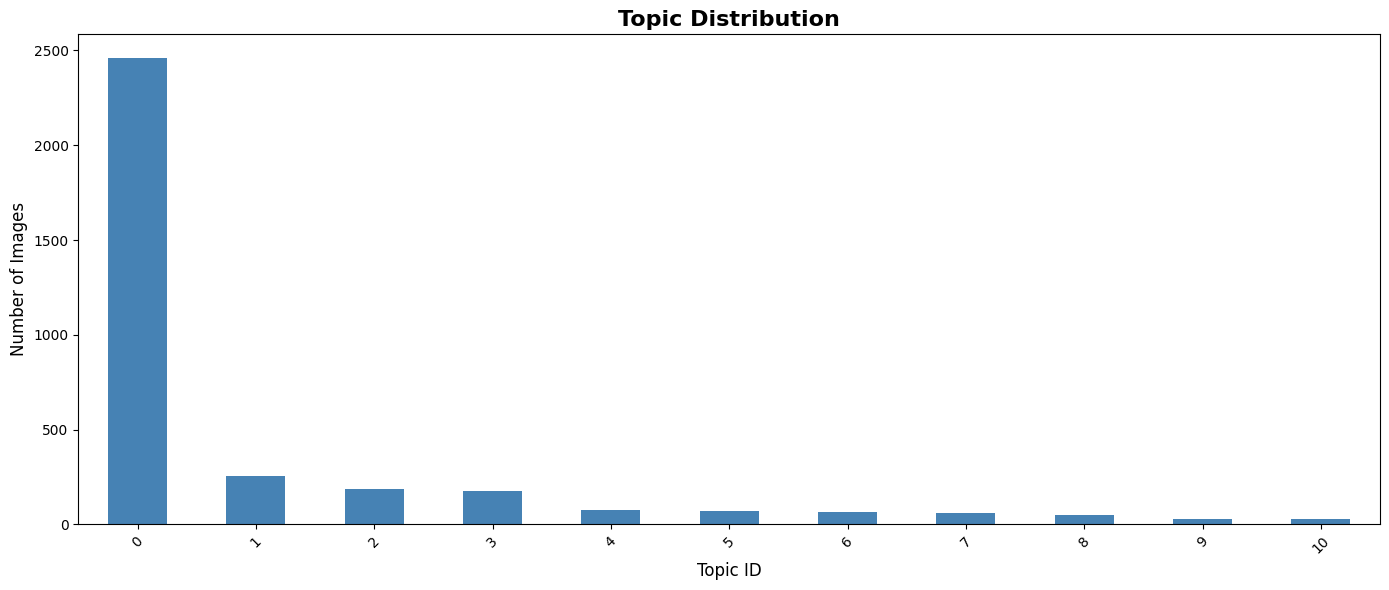

In [10]:
visualize_topics(topic_model, labeled_df, n_topics=6)

## 8. Run Prediction

In [11]:
conf_matrix, classifier_model, metrics = predict(
    labeled_df=labeled_df,
    embeddings=embeddings,
    test_size=0.3,
    classifier='random_forest'
)

Removed 1533 outliers
Training on 3467 samples with 11 classes
Train: 2426 | Test: 1041

Accuracy: 0.8636

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       739
           1       0.99      0.89      0.94        76
           2       1.00      0.48      0.65        56
           3       1.00      0.25      0.39        53
           4       1.00      0.48      0.65        23
           5       1.00      0.71      0.83        21
           6       1.00      0.40      0.57        20
           7       1.00      0.42      0.59        19
           8       1.00      0.62      0.77        16
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00         9

    accuracy                           0.86      1041
   macro avg       0.80      0.48      0.57      1041
weighted avg       0.87      0.86      0.84      1041



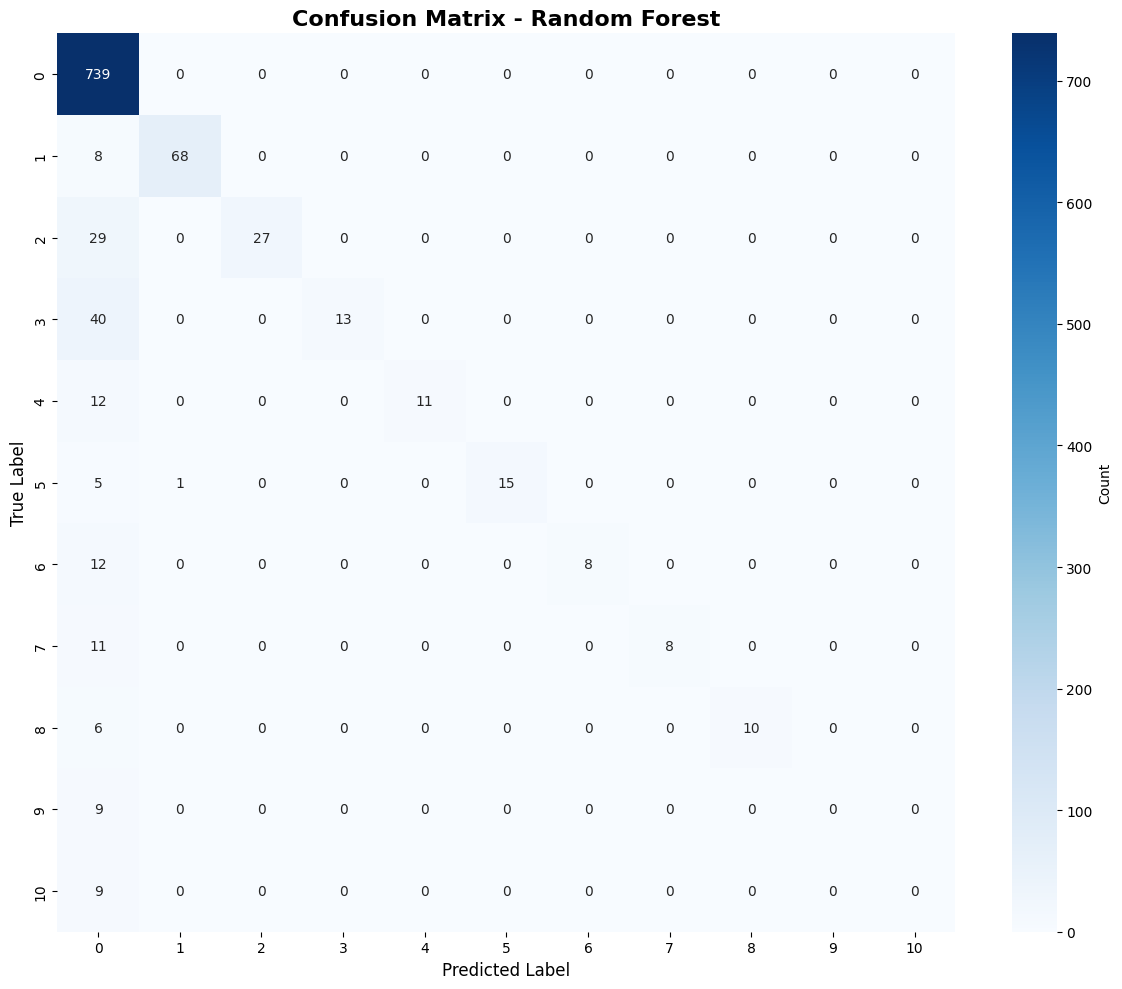

In [12]:
plot_confusion_matrix(conf_matrix, title='Confusion Matrix - Random Forest')

## 9. Model Comparison

In [13]:
# Compare different classifiers
classifiers = ['random_forest', 'logistic', 'svm']
results = {}

for clf_name in classifiers:
    print(f"\nTesting {clf_name}...")
    conf_mat, model, met = predict(labeled_df, embeddings, classifier=clf_name)
    results[clf_name] = {'confusion_matrix': conf_mat, 'accuracy': met['accuracy']}

# Compare accuracies
print("\n" + "="*60)
print("CLASSIFIER COMPARISON")
print("="*60)
for clf_name, result in results.items():
    print(f"{clf_name:20s}: {result['accuracy']:.4f}")


Testing random_forest...
Removed 1533 outliers
Training on 3467 samples with 11 classes
Train: 2426 | Test: 1041

Accuracy: 0.8636

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       739
           1       0.99      0.89      0.94        76
           2       1.00      0.48      0.65        56
           3       1.00      0.25      0.39        53
           4       1.00      0.48      0.65        23
           5       1.00      0.71      0.83        21
           6       1.00      0.40      0.57        20
           7       1.00      0.42      0.59        19
           8       1.00      0.62      0.77        16
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00         9

    accuracy                           0.86      1041
   macro avg       0.80      0.48      0.57      1041
weighted avg       0.87      0.86      0.84      1041


Testing logistic...
Removed 15

## 10. Summary

This notebook successfully implements visual data prediction using multimodal topic mining.

**Dataset:** 5,000 images from Flickr30k (31,783 total available)

**Topic Discovery:**
- Discovered **11 topics** using BERTopic with CLIP embeddings
- Combined image + caption features for richer representations
- Outliers: 1,533 images (30.7%) - diverse content outside main clusters

**Classification Performance:**
- **Best Model:** Logistic Regression - **97.6% accuracy**
- SVM: 97.1% accuracy  
- Random Forest: 86.4% accuracy

**Key Insights:**
1. Multimodal embeddings (image + text) enable effective topic discovery
2. CLIP embeddings capture semantic similarities across modalities
3. Simple linear models (Logistic Regression) work exceptionally well on high-quality embeddings
4. Most topics are well-separated in embedding space (high precision/recall)

**Functions Delivered:**
- ✅ `topic_miner()` - Multimodal topic discovery with BERTopic
- ✅ `predict()` - Classification with confusion matrix output